Objective: pearson_correlation_coefficient
Optimizer: differential_evolution


differential_evolution optimizing:   0%|           0/1000 [ETA: ?, Elapsed: 00:00]

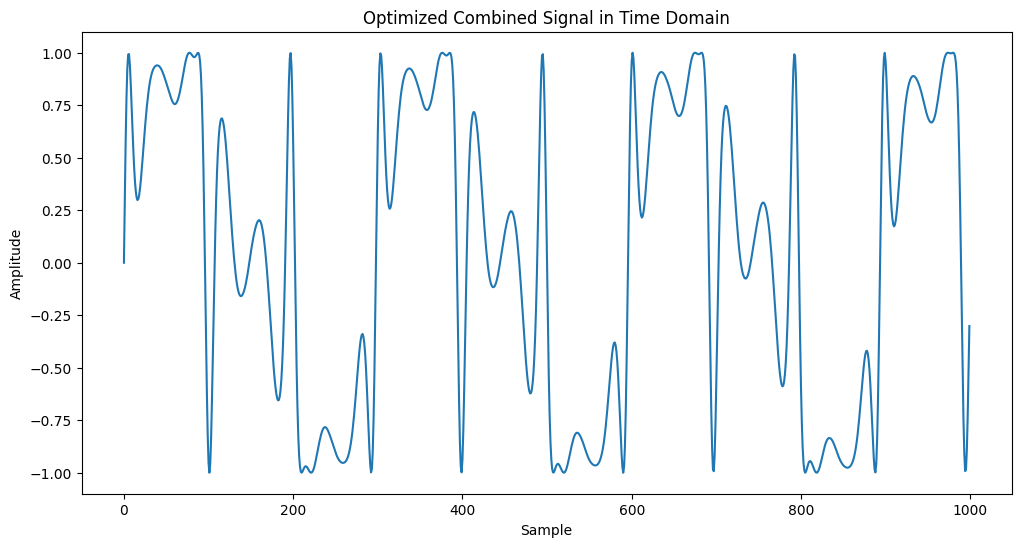

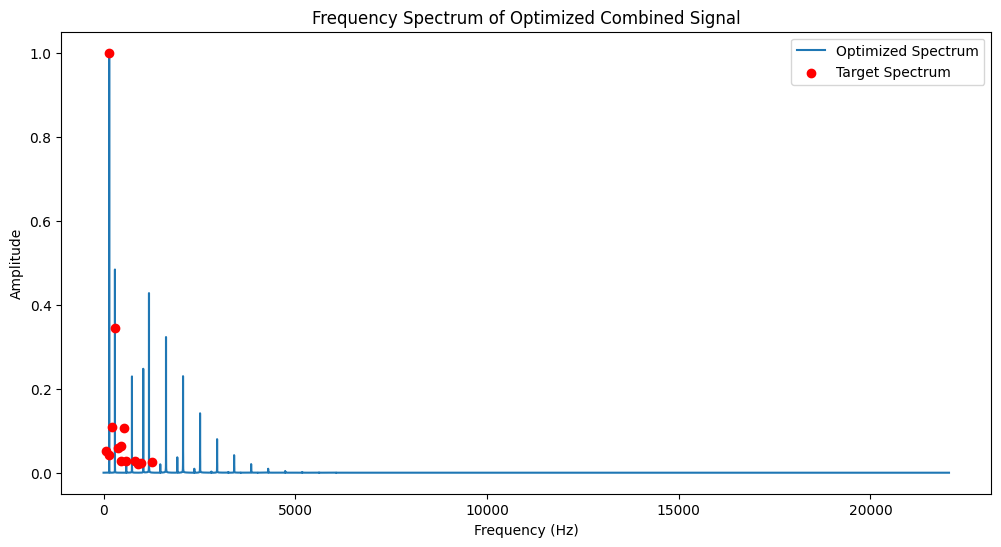

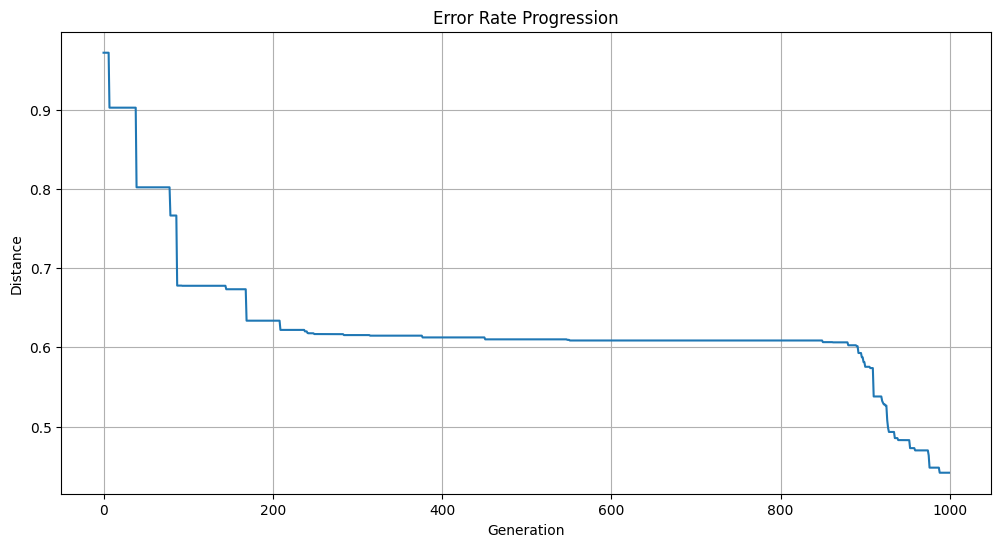

Modulator 4:

    Frequency: 3872.4208111279745
    Amplitude: 0.0011312871404661135

Modulator 3:

    Frequency: 444.0259011339225
    Amplitude: 0.8842289858365586

Modulator 2:

    Frequency: 444.0286153098969
    Amplitude: 2.201607041870038

Modulator 1:

    Frequency: 297.02934545506054
    Amplitude: 1.6777313608736795

[2025-08-28 18:41:31] 16-bit wave file with 44.1kHz sampling rate saved successfully to: c:\Users\egorp\Nextcloud\code\public_repos\FFTimbre\rendered_audio\optimized_output_fm_cellotest.wav


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, dual_annealing
from tqdm.auto import tqdm
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr
import librosa
import os
from IPython.display import Audio, display
from py_scripts.generate_wave_file import generate_wave_file

# Load TSV file into a DataFrame
file_path = 'tsv/cello_single.tsv'
df = pd.read_csv(file_path, sep='\t')

# Extract frequencies and amplitudes
frequencies = df['Frequency (Hz)'].values
amplitudes = df['Amplitude'].values

# Normalize amplitudes
amplitudes /= np.max(amplitudes)

# Parameters
duration = 1.0  # seconds
sample_rate = 44100  # samples per second

# Waveform generator for sine wave
def sine_wave(frequency, amplitude, duration, sample_rate, modulator=None):
    time_vector = np.linspace(0, duration, int(sample_rate * duration))
    if modulator is not None:
        return amplitude * np.sin(2 * np.pi * frequency * time_vector + modulator)
    return amplitude * np.sin(2 * np.pi * frequency * time_vector)

# FM modulation setup
def fm_modulate(carrier_freq, carrier_amp, modulator_signal, duration, sample_rate):
    time_vector = np.linspace(0, duration, int(sample_rate * duration))
    return carrier_amp * np.sin(2 * np.pi * carrier_freq * time_vector + modulator_signal)

# Compute MFCC
def compute_mfcc(signal, sample_rate, n_mfcc=20):
    mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs, axis=1)
    return mfccs_mean

# Objective function template
def compute_objective(params, target_freqs, target_amps, duration, sample_rate, objective_type, target_mfcc_mean=None):
    combined_signal = np.zeros(int(sample_rate * duration))
    
    # Unpack parameters for each oscillator
    freq4, amp4 = params[0], params[1]
    freq3, amp3 = params[2], params[3]
    freq2, amp2 = params[4], params[5]
    freq1, amp1 = params[6], params[7]

    # Generate modulator signals
    mod4 = sine_wave(freq4, amp4, duration, sample_rate)
    mod3 = fm_modulate(freq3, amp3, mod4, duration, sample_rate)
    mod2 = fm_modulate(freq2, amp2, mod3, duration, sample_rate)
    combined_signal += fm_modulate(freq1, amp1, mod2, duration, sample_rate)
    
    # Normalize combined signal
    max_val = np.max(np.abs(combined_signal))
    if max_val > 0:
        combined_signal /= max_val
    
    # Compute FFT
    fft_result = np.abs(np.fft.fft(combined_signal))
    fft_freqs = np.fft.fftfreq(len(fft_result), 1/sample_rate)
    
    # Compute the target spectrum
    target_spectrum = np.zeros_like(fft_result)
    for target_freq, target_amp in zip(target_freqs, target_amps):
        closest_index = np.argmin(np.abs(fft_freqs - target_freq))
        target_spectrum[closest_index] = target_amp
    
    epsilon = 1e-10  # Small value to avoid log(0) and division by zero
    
    if objective_type == 'itakura_saito':
        is_distance = np.sum((target_spectrum + epsilon) / (fft_result + epsilon) - np.log((target_spectrum + epsilon) / (fft_result + epsilon)) - 1)
        return is_distance
    
    elif objective_type == 'spectral_convergence':
        spectral_convergence = np.linalg.norm(np.abs(fft_result) - np.abs(target_spectrum)) / np.linalg.norm(np.abs(target_spectrum))
        return spectral_convergence
    
    elif objective_type == 'cosine_similarity':
        cosine_sim = cosine(np.abs(fft_result), np.abs(target_spectrum))
        return cosine_sim
    
    elif objective_type == 'euclidean_distance':
        euclidean_distance = np.linalg.norm(np.abs(fft_result) - np.abs(target_spectrum))
        return euclidean_distance
    
    elif objective_type == 'manhattan_distance':
        manhattan_distance = np.sum(np.abs(np.abs(fft_result) - np.abs(target_spectrum)))
        return manhattan_distance
    
    elif objective_type == 'kullback_leibler_divergence':
        kl_divergence = np.sum(target_spectrum * np.log((target_spectrum + epsilon) / (fft_result + epsilon)))
        return kl_divergence

    elif objective_type == 'pearson_correlation_coefficient':
        pearson_corr, _ = pearsonr(np.abs(fft_result), target_spectrum)
        return 1 - pearson_corr  # We subtract from 1 because we want to minimize this objective function
    
    elif objective_type == 'mfcc_distance':
        generated_mfcc_mean = compute_mfcc(combined_signal, sample_rate)
        mfcc_distance = np.linalg.norm(generated_mfcc_mean - target_mfcc_mean)
        return mfcc_distance

# Compute target MFCC mean
target_signal = np.zeros(int(sample_rate * duration))
for freq, amp in zip(frequencies, amplitudes):
    target_signal += sine_wave(freq, amp, duration, sample_rate)
target_signal /= np.max(np.abs(target_signal))
target_mfcc_mean = compute_mfcc(target_signal, sample_rate)

# Choose objective function
objective_type = 'pearson_correlation_coefficient'  # Change this to desired objective type
print(f"Objective: {objective_type}")

objective_function = lambda params, target_freqs, target_amps, duration, sample_rate: compute_objective(params, target_freqs, target_amps, duration, sample_rate, objective_type, target_mfcc_mean)

# Optimization constraints
bounds = [
    (50, 5000),  # Frequency bounds for osc4
    (0, 12),  # Amplitude bounds for osc4
    (50, 5000),  # Frequency bounds for osc3
    (0, 12),  # Amplitude bounds for osc3
    (50, 5000),  # Frequency bounds for osc2
    (0, 12),  # Amplitude bounds for osc2
    (50, 5000),  # Frequency bounds for osc1
    (0, 12)   # Amplitude bounds for osc1
]

# Select optimization method
optimization_method = 'differential_evolution'  # Change this to 'differential_evolution' for using differential evolution
print(f"Optimizer: {optimization_method}")

# Initialize progress bar and error history
n_generations = 1000  # Adjusted for faster convergence
progress = tqdm(total=n_generations, unit=' iteration', desc=f"{optimization_method} optimizing", bar_format='{l_bar}{bar} {n}/{total} [ETA: {remaining}, Elapsed: {elapsed}]')
error_history = []

# Callback function to update progress bar and error history
def callback(param, convergence=None, context=None):
    error = objective_function(param, frequencies, amplitudes, duration, sample_rate)
    error_history.append(error)
    progress.update(1)

# Run optimization
if optimization_method == 'differential_evolution':
    result = differential_evolution(objective_function, bounds, args=(frequencies, amplitudes, duration, sample_rate), strategy='best1bin', maxiter=n_generations, popsize=10, tol=1e-6, mutation=(0.5, 1), recombination=0.7, callback=callback)
elif optimization_method == 'dual_annealing':
    result = dual_annealing(objective_function, bounds, args=(frequencies, amplitudes, duration, sample_rate), maxiter=n_generations, callback=lambda x, f, context: callback(x, f))

# Close progress bar
progress.close()

# Extract optimal parameters
optimal_params = result.x
optimal_frequencies = optimal_params[0::2]
optimal_amplitudes = optimal_params[1::2]

# Generate combined signal using optimal parameters
mod4 = sine_wave(optimal_frequencies[0], optimal_amplitudes[0], duration, sample_rate)
mod3 = fm_modulate(optimal_frequencies[1], optimal_amplitudes[1], mod4, duration, sample_rate)
mod2 = fm_modulate(optimal_frequencies[2], optimal_amplitudes[2], mod3, duration, sample_rate)
combined_signal = fm_modulate(optimal_frequencies[3], optimal_amplitudes[3], mod2, duration, sample_rate)

# Normalize combined signal
max_val = np.max(np.abs(combined_signal))
if max_val > 0:
    combined_signal /= max_val

# Compute FFT for plotting
fft_result = np.fft.fft(combined_signal)
fft_freqs = np.fft.fftfreq(len(fft_result), 1/sample_rate)
fft_result_np = np.abs(fft_result)

# Normalize the FFT result for comparison
fft_result_np /= np.max(fft_result_np)

# Time domain plot
plt.figure(figsize=(12, 6))
plt.plot(combined_signal[:1000])  # Plot the first 1000 samples
plt.title('Optimized Combined Signal in Time Domain')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

# Frequency domain plot
plt.figure(figsize=(12, 6))
plt.plot(fft_freqs[:len(fft_freqs)//2], fft_result_np[:len(fft_result_np)//2], label='Optimized Spectrum')
plt.scatter(frequencies, amplitudes, color='red', label='Target Spectrum', zorder=5)
plt.title('Frequency Spectrum of Optimized Combined Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Plot error history
plt.figure(figsize=(12, 6))
plt.plot(error_history)
plt.title('Error Rate Progression')
plt.xlabel('Generation')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

# Print optimal parameters in the specified format
for i, (freq, amp) in enumerate(zip(optimal_frequencies, optimal_amplitudes)):
    print(f"Modulator {4-i}:\n")
    print(f"    Frequency: {freq}")
    print(f"    Amplitude: {amp}\n")

# Synthesize and save the audio using the provided script
output_filename = 'optimized_output_fm_cellotest.wav'
generate_wave_file(combined_signal, sample_rate, fs_target_name='44.1kHz', custom_filename=output_filename, save_to_file=True)

output_path = os.path.join('rendered_audio', output_filename)
display(Audio(filename=output_path))


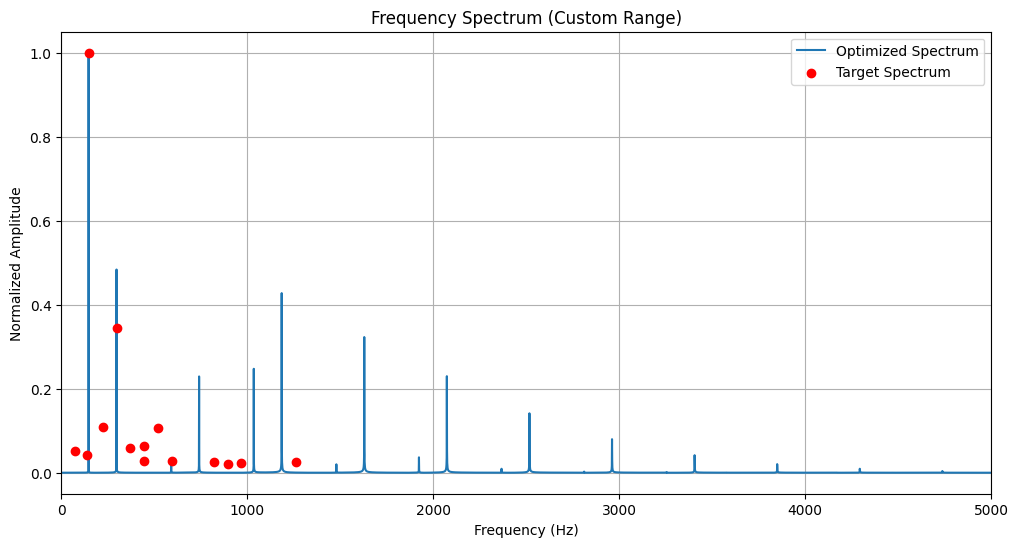

In [11]:
# Frequency-domain plot with customizable range and x-resolution
# Set your desired frequency range and plotting step in Hz
freq_min = 0.0      # Hz
freq_max = 5000     # None = auto to Nyquist (matches Cell 0 default view)
plot_step_hz = 1 # None = no downsampling (matches Cell 0)

# Controls
recompute_fft = False   # False uses fft from Cell 0; True recomputes from combined_signal
norm_mode = 'global'    # 'global' | 'range' | 'none'
db_scale = False        # True to show dB scale

# Select spectrum source
if not recompute_fft and 'fft_freqs' in globals() and 'fft_result_np' in globals():
    positive_mask = (fft_freqs >= 0)
    freqs_all = fft_freqs[positive_mask]
    spectrum_all = fft_result_np[positive_mask]
else:
    if 'combined_signal' not in globals() or 'sample_rate' not in globals():
        raise NameError("combined_signal/sample_rate not found. Run the optimization cell first.")
    freqs_all = np.fft.rfftfreq(len(combined_signal), 1/sample_rate)
    spectrum_all = np.abs(np.fft.rfft(combined_signal))

    # Apply global normalization if requested (when recomputing)
    if norm_mode == 'global' and spectrum_all.max() > 0:
        spectrum_all = spectrum_all / spectrum_all.max()

# Auto freq_max to Nyquist if not provided
if freq_max is None:
    freq_max = float(freqs_all.max())

# Filter by desired range
range_mask = (freqs_all >= freq_min) & (freqs_all <= freq_max)
freqs_range = freqs_all[range_mask]
spec_range = spectrum_all[range_mask]

# Range-based normalization
if norm_mode == 'range':
    max_in_range = spec_range.max()
    if max_in_range > 0:
        spec_range = spec_range / max_in_range

# Convert to dB if selected
ylabel = 'Normalized Amplitude' if norm_mode in ('global', 'range') else 'Amplitude'
if db_scale:
    epsilon = 1e-12
    spec_range = 20 * np.log10(np.clip(spec_range, epsilon, None))
    ylabel = 'Magnitude (dBFS)'

# Downsample for plotting density control
if len(freqs_range) > 1 and plot_step_hz is not None and plot_step_hz > 0:
    bin_spacing_hz = freqs_range[1] - freqs_range[0]
    step_n = max(1, int(round(plot_step_hz / bin_spacing_hz)))
else:
    step_n = 1

freqs_plot = freqs_range[::step_n]
spectrum_plot = spec_range[::step_n]

# Target spectrum in range
if 'frequencies' in globals() and 'amplitudes' in globals():
    target_mask = (frequencies >= freq_min) & (frequencies <= freq_max)
    target_freqs = frequencies[target_mask]
    target_amps = amplitudes[target_mask]
    if db_scale:
        target_amps_plot = 20 * np.log10(np.clip(target_amps, 1e-12, None))
    else:
        target_amps_plot = target_amps
else:
    target_freqs = np.array([])
    target_amps_plot = np.array([])

plt.figure(figsize=(12, 6))
plt.plot(freqs_plot, spectrum_plot, label='Optimized Spectrum')
if target_freqs.size > 0:
    plt.scatter(target_freqs, target_amps_plot, color='red', label='Target Spectrum', zorder=5)
plt.title('Frequency Spectrum (Custom Range)')
plt.xlabel('Frequency (Hz)')
plt.ylabel(ylabel)
plt.xlim(freq_min, freq_max)
plt.grid(True)
plt.legend()
plt.show()


In [13]:
# Render a longer version of the optimized FM signal
# Set desired duration in seconds for the rendered audio
render_duration_sec = 10.0  # e.g., 5 or 10 seconds
fs_render = sample_rate     # base rate prior to resampling in generate_wave_file

# Re-synthesize the optimized FM chain for the new duration
mod4_long = sine_wave(optimal_frequencies[0], optimal_amplitudes[0], render_duration_sec, fs_render)
mod3_long = fm_modulate(optimal_frequencies[1], optimal_amplitudes[1], mod4_long, render_duration_sec, fs_render)
mod2_long = fm_modulate(optimal_frequencies[2], optimal_amplitudes[2], mod3_long, render_duration_sec, fs_render)
long_signal = fm_modulate(optimal_frequencies[3], optimal_amplitudes[3], mod2_long, render_duration_sec, fs_render)

# Normalize
max_val = np.max(np.abs(long_signal))
if max_val > 0:
    long_signal = long_signal / max_val

# Save using existing utility (keeps consistent pathing and format)
long_output_filename = f"optimized_output_fm_cellotest_long_{int(render_duration_sec)}s.wav"
file_path = generate_wave_file(long_signal, fs_render, fs_target_name='44.1kHz', custom_filename=long_output_filename, save_to_file=True)

display(Audio(filename=file_path))


[2025-08-28 19:23:05] 16-bit wave file with 44.1kHz sampling rate saved successfully to: c:\Users\egorp\Nextcloud\code\public_repos\FFTimbre\rendered_audio\optimized_output_fm_cellotest_long_10s.wav


In [14]:
# Define the filename
tsv_filename = 'tsv/final_values_fm.tsv'

# Create the DataFrame
final_values_df = pd.DataFrame({
    'Modulator': [1, 2, 3, 4],
    'Frequency (Hz)': optimal_frequencies[::-1],
    'Amplitude': optimal_amplitudes[::-1]
})

# Display the DataFrame
display(final_values_df)

# Save the DataFrame as a TSV file
final_values_df.to_csv(tsv_filename, sep='\t', index=False)

# Print the location where the TSV file was saved
print(f"TSV file was saved at: {os.path.abspath(tsv_filename)}")

,Modulator,Frequency (Hz),Amplitude
0,1,297.029345,1.677731
1,2,444.028615,2.201607
2,3,444.025901,0.884229
3,4,3872.420811,0.001131


TSV file was saved at: c:\Users\egorp\Nextcloud\code\public_repos\FFTimbre\tsv\final_values_fm.tsv
